In [19]:
from keras.preprocessing import sequence  
from keras.models import Sequential  
from keras.datasets import boston_housing 
from keras.layers import Dense, Dropout, LSTM
# from keras.utils import multi_gpu_model  
# from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
from keras import regularizers  # 正则化  
import matplotlib.pyplot as plt  
import numpy as np
from sklearn.preprocessing import MinMaxScaler  
import pandas as pd

In [73]:
from sklearn.utils import shuffle  

# 加载数据集
def load_data(data_path, shuff=True):
    data = pd.read_csv(data_path)
    data = data.fillna(-1)  # Nan值填充
#     print(data.iloc[1000])
    if shuff:   # 将数据集打乱
        data = shuffle(data)
#     print(data.iloc[1000])
    # 构建数据集和标签
    samples = []
    labels = []
    for index, row in data.iterrows():
    # print(row) # 输出每行的索引值
        matrix = []  # 7 * 4
        for i in range(7):
            matrix.append([i+1,
                           row['AsuLevel_' + str(i+1)],
                           row['SignalLevel_' + str(i+1)],
                           row['Dbm_' + str(i+1)]]) # 新数据集中不存在RSSI，使用Dbm(代功率的绝对值)
        # print(matrix)
        samples.append(matrix)
        labels.append([row['Longitude'], row['Latitude']])
    return np.array(samples), np.array(labels)

In [95]:
# 度量两点距离
import math
def rad(d):
    return d * math.pi / 180.0

# 地理坐标系：为球面坐标。 参考平面地是椭球面，坐标单位：经纬度；
# 投影坐标系：为平面坐标。参考平面地是水平面，坐标单位：米、千米等；
# 地理坐标转换到投影坐标的过程可理解为投影。（投影：将不规则的地球曲面转换为平面）

# 目前国内主要有三种地理坐标系
# 1、WGS84坐标系：即地球坐标系（World Geodetic System），国际上通用的坐标系。
# 设备包含的GPS芯片或者北斗芯片获取的经纬度一般都是为WGS84地理坐标系，目前谷歌地图采用的是WGS84坐标系（中国范围除外）。
# 2、GCJ02坐标系：即火星坐标系，国测局坐标系。是由中国国家测绘局制定。由WGS84坐标系经加密后的坐标系。谷歌中国和搜搜中国采用。
# 3、BD09坐标系：百度坐标系，GCJ02坐标系经加密后的坐标系。

# 投影：墨卡托投影、高斯-克吕格 (Gauss-Krüger) 投影
# 感兴趣的同学可以在https://desktop.arcgis.com/zh-cn/arcmap/10.3/guide-books/map-projections/list-of-supported-map-projections.htm深入了解

# gps两点间距离（单位为米）
def distance(true_pt, pred_pt):
    lat1 = float(true_pt[1])
    lng1 = float(true_pt[0])
    lat2 = float(pred_pt[1])
    lng2 = float(pred_pt[0])
    radLat1 = rad(lat1)
    radLat2 = rad(lat2)
    a = radLat1 - radLat2
    b = rad(lng1) - rad(lng2)
    s = 2 * math.asin(math.sqrt(math.pow(math.sin(a/2),2) +
    math.cos(radLat1)*math.cos(radLat2)*math.pow(math.sin(b/2),2)))
    s = s * 6378.137
    s = round(s * 10000) / 10
    return s

In [146]:
path = r"./siping_4g.csv"
samples, labels = load_data(path)
print(samples.shape)
print(labels.shape)
print(samples[0], labels[0])

(3479, 7, 4)
(3479, 2)
[[  1.  69.   4. -71.]
 [  2.  62.   4. -78.]
 [  3.  57.   4. -83.]
 [  4.  96.   4. -44.]
 [  5.  -1.  -1.  -1.]
 [  6.  -1.  -1.  -1.]
 [  7.  -1.  -1.  -1.]] [121.4960706   31.28294881]


In [147]:
# 数据变形： (3479, 7, 4)---》 (3479, 7, 4，1)
# samples = samples.reshape(-1, 7,4,1) # -1自动计算
samples = samples.reshape(samples.shape[0], -1)
print(samples.shape)

from sklearn.model_selection import train_test_split

# 划分数据集
x_train, x_valid, y_train, y_valid = train_test_split(samples, labels, test_size=0.2)  #划分训练数据、训练标签、验证数据、验证标签

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(3479, 28)
(2783, 28)
(696, 28)
(2783, 2)
(696, 2)


In [148]:
# 转成DataFrame格式方便数据处理
x_train_pd = pd.DataFrame(x_train)  
y_train_pd = pd.DataFrame(y_train)  
x_valid_pd = pd.DataFrame(x_valid)  
y_valid_pd = pd.DataFrame(y_valid)  
# print(x_train_pd.head(5)) 
# print('-------------------') 
# print(y_train_pd.head(5))

# 训练集归一化  
min_max_scaler = MinMaxScaler()  
min_max_scaler.fit(x_train)  
x_train = min_max_scaler.transform(x_train_pd)  

min_max_scaler.fit(y_train)  
y_train = min_max_scaler.transform(y_train_pd)  
  
# 验证集归一化  
min_max_scaler.fit(x_valid)  
x_valid = min_max_scaler.transform(x_valid_pd)  

min_max_scaler.fit(y_valid)  
y_valid = min_max_scaler.transform(y_valid_pd)
x_train=x_train.reshape(-1,7,4)
y_train=y_train.reshape(-1,2)
x_valid=x_valid.reshape(-1,7,4)
y_valid=y_valid.reshape(-1,2)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(2783, 7, 4)
(2783, 2)
(696, 7, 4)
(696, 2)


In [158]:
# 超参数
epochs = 5
batch_size = 16
# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim：输入单个样本特征值的维度
# input_length：输入的时间点长度
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1]))
model.add(LSTM(units=50))
model.add(Dense(2))

print(model.summary())  # 打印网络层次结构
model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
history = model.fit(x_train, y_train,
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    validation_data=(x_valid, y_valid) 
                    )

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 7, 100)            42000     
                                                                 
 lstm_52 (LSTM)              (None, 50)                30200     
                                                                 
 dense_21 (Dense)            (None, 2)                 102       
                                                                 
Total params: 72,302
Trainable params: 72,302
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
174/174 [==============================] - 5s 9ms/step - loss: 0.0853 - val_loss: 7804.5059
Epoch 2/5
174/174 [==============================] - 1s 4ms/step - loss: 0.0788 - val_loss: 7814.9150
Epoch 3/5
174/174 [==============================] - 1s 5ms/step - loss: 0.0775 - val_loss: 7812.7520
Ep

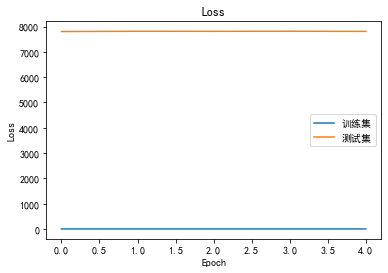

In [159]:
import matplotlib.pyplot as plt 
# 绘制训练 & 验证的损失值  
from pylab import mpl # 设置显示中文字体 
mpl.rcParams["font.sans-serif"] = ["SimHei"]
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['训练集', '测试集'], loc='best')  
plt.show()

In [150]:
y_new = model.predict(x_valid)
min_max_scaler.fit_transform(y_valid_pd)
# 反归一化
y_new = min_max_scaler.inverse_transform(y_new)
y_valid = min_max_scaler.inverse_transform(y_valid)

# print(y_new.shape)
# print(y_valid.shape)

22/22 [==============================] - 1s 2ms/step
(696, 2)
(696, 2)


In [151]:
y_new = model.predict(x_valid)
min_max_scaler.fit_transform(y_valid_pd)
# 反归一化
y_new = min_max_scaler.inverse_transform(y_new)
y_valid = min_max_scaler.inverse_transform(y_valid)

# print(y_new.shape)
# print(y_valid.shape)
err = [distance(p,t) for p, t in zip(y_valid, y_new)]

print('平均绝对误差 MAE : ', '%.4f'% np.mean(np.abs(err)))
print('均方误差 MSE : ', '%.4f'% np.mean(np.square(err)))
percentage_err = np.abs(err - np.mean(err)) / np.mean(err)
print('平均绝对百分比误差 MAPE : ', '%.4f'% np.mean(percentage_err))
print('绝对误差中位数 MedAE : ', '%.4f'% np.median(err))

平均绝对误差 MAE :  250.6841
均方误差 MSE :  86331.8491
平均绝对百分比误差 MAPE :  0.5091
绝对误差中位数 MedAE :  230.0000


253.1383620689655

In [72]:
for i in range(len(y_new)):
    print(y_valid[i], y_new[i])

[121.4961035   31.28354653] [121.49726   31.284073]
[121.4994009   31.28594976] [121.49703   31.284548]
[121.4949791   31.28358106] [121.49705   31.284182]
[121.5035805   31.28365874] [121.49881   31.284487]
[121.4954204  31.283646 ] [121.496994  31.284464]
[121.4938443   31.28455312] [121.49707   31.284576]
[121.5013504   31.28496175] [121.49698   31.284502]
[121.4954829  31.2832667] [121.49742   31.284166]
[121.4960706   31.28294881] [121.49721   31.284744]
[121.4925727  31.2843484] [121.49701   31.284422]
[121.4973961  31.285062 ] [121.49726   31.284746]
[121.4960706   31.28294881] [121.49728   31.284758]
[121.5035873   31.28366544] [121.49913  31.28463]
[121.4940567   31.28409229] [121.49736   31.284842]
[121.4990996   31.28571296] [121.49712   31.284618]
[121.500988    31.28571026] [121.49776   31.284275]
[121.4966909   31.28661194] [121.49772   31.285185]
[121.50051    31.2849864] [121.4978    31.285261]
[121.5024477  31.2863657] [121.497055  31.284649]
[121.4960706   31.28294881

[121.4973961  31.285062 ] [121.498146  31.284256]
[121.4994009   31.28594976] [121.49711   31.284616]
[121.4954682   31.28620791] [121.49711   31.284267]
[121.4960706   31.28294881] [121.49682   31.284237]
[121.4955601   31.28356162] [121.49736  31.2842 ]
[121.4960706   31.28294881] [121.4979    31.284199]
[121.4925751  31.2843533] [121.497025  31.284428]
[121.4943731   31.28666153] [121.49604  31.28384]
[121.4966909   31.28661194] [121.497795  31.285252]
[121.4960706   31.28294881] [121.49656   31.283915]
[121.5004614   31.28606491] [121.49789  31.28535]
[121.49543     31.28363494] [121.497025  31.284487]
[121.496297    31.28354031] [121.49692   31.284142]
[121.5035997   31.28369744] [121.498886  31.28449 ]
[121.4952597   31.28490205] [121.496956  31.284414]
[121.4994009   31.28594976] [121.49677   31.284163]
[121.4929114   31.28530074] [121.49723   31.284723]
[121.4947811  31.2864806] [121.497696  31.285162]
[121.4935505   31.28427968] [121.496895  31.284317]
[121.4929114   31.285300